In [1]:
%run ../../shared_setup.ipynb

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [2]:
def impute_inheritance_nearest(inheritance, pos, pos_impute):
    """Impute inheritance at unknown positions, by copying from
    nearest neighbouring position where inheritance is known.

    Parameters
    ----------

    inheritance : array_like, int, shape (n_variants, n_gametes)
        An array of integers coding the allelic inheritance state at the
        known positions.
    pos : array_like, int, shape (n_variants,)
        Array of genomic positions at which `inheritance` was determined.
    pos_impute : array_like, int
        Array of positions at which to impute inheritance.

    Returns
    -------

    imputed_inheritance : ndarray, int
        An array of integers coding the imputed allelic inheritance.

    """

    # check inputs
    inheritance = np.asarray(inheritance)
    assert inheritance.ndim == 2
    pos = np.asarray(pos)
    assert pos.ndim == 1
    pos_impute = np.asarray(pos_impute)
    assert pos_impute.ndim == 1
    n_variants = pos.size
    assert inheritance.shape[0] == n_variants

    # find indices of neighbouring variants
    indices_left = np.clip(np.searchsorted(pos, pos_impute), 0, n_variants - 1)
    indices_right = np.clip(indices_left + 1, 0, n_variants - 1)
    inh_left = np.take(inheritance, indices_left, axis=0)
    inh_right = np.take(inheritance, indices_right, axis=0)

    # find positions of neighbouring variants
    pos_left = np.take(pos, indices_left)
    pos_right = np.take(pos, indices_right)

    # compute distance to neighbours
    dist_left = np.abs(pos_impute - pos_left)
    dist_right = np.abs(pos_right - pos_impute)

    # build output
    out = np.zeros_like(inh_left)
    out[(dist_left <= dist_right)] = inh_left[(dist_left <= dist_right)]
    out[(dist_left > dist_right)] = inh_right[(dist_left > dist_right)]

    return out


In [3]:
def impute_inheritance_neighbours(inheritance, pos, pos_impute):
    """Impute inheritance at unknown positions, by copying from
    neighbouring position where inheritance is known.

    Parameters
    ----------

    inheritance : array_like, int, shape (n_variants, n_gametes)
        An array of integers coding the allelic inheritance state at the
        known positions.
    pos : array_like, int, shape (n_variants,)
        Array of genomic positions at which `inheritance` was determined.
    pos_impute : array_like, int
        Array of positions at which to impute inheritance.

    Returns
    -------

    imputed_inheritance : ndarray, int
        An array of integers coding the imputed allelic inheritance.

    """

    # check inputs
    inheritance = np.asarray(inheritance)
    assert inheritance.ndim == 2
    pos = np.asarray(pos)
    assert pos.ndim == 1
    pos_impute = np.asarray(pos_impute)
    assert pos_impute.ndim == 1
    n_variants = pos.size
    assert inheritance.shape[0] == n_variants

    # find indices of neighbouring variants
    indices_left = np.clip(np.searchsorted(pos, pos_impute), 0, n_variants - 1)
    indices_right = np.clip(indices_left + 1, 0, n_variants - 1)
    inh_left = np.take(inheritance, indices_left, axis=0)
    inh_right = np.take(inheritance, indices_right, axis=0)

    # build output
    pos_left = np.take(pos, indices_left)
    out = np.zeros_like(inh_left)
    out[inh_left == inh_right] = inh_left[inh_left == inh_right]
    out[pos_left == pos_impute] = inh_left[pos_left == pos_impute]

    return out


In [4]:
gatk = load_callsets(GATK_CALLSET_FN_TEMPLATE,
                     variant_filter='FILTER_PASS',
                     call_filter=gatk_conf_calls)

2015-05-07 08:47:24.616837 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.gatk.final.npz
2015-05-07 08:47:25.579533 :: filter variants: excluding 155288 (80.9%) retaining 36598 (19.1%) of 191886 variants
2015-05-07 08:47:25.615839 :: filter calls: excluding 1413 (0.2%) retaining 767145 (99.8%) of 768558 calls
2015-05-07 08:47:25.616820 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/hb3_dd2.gatk.final.npz
2015-05-07 08:47:28.011351 :: filter variants: excluding 345466 (92.2%) retaining 29067 (7.8%) of 374533 variants
2015-05-07 08:47:28.040393 :: filter calls: excluding 14495 (1.3%) retaining 1060984 (98.7%) of 1075479 calls
2015-05-07 08:47:28.041709 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/7g8_gb4.gatk.final.npz
2015-05-07 08:47:30.692143 :: filter variants: excluding 358058 (92.8%) retaining 27709 (7.2%) of 385767 variants
2015-05-07 08:47:30.722598 :: filter calls: excluding 7569 (0.7%) retainin

In [5]:
cortex = load_callsets(CORTEX_CALLSET_FN_TEMPLATE, 
                       variant_filter='FILTER_PASS',
                       call_filter=cortex_conf_calls)

2015-05-07 08:47:30.727368 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.cortex.final.npz
2015-05-07 08:47:30.949541 :: filter variants: excluding 29576 (52.0%) retaining 27296 (48.0%) of 56872 variants
2015-05-07 08:47:30.962788 :: filter calls: excluding 4849 (0.8%) retaining 568367 (99.2%) of 573216 calls
2015-05-07 08:47:30.963645 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/hb3_dd2.cortex.final.npz
2015-05-07 08:47:31.522485 :: filter variants: excluding 80272 (75.3%) retaining 26293 (24.7%) of 106565 variants
2015-05-07 08:47:31.545641 :: filter calls: excluding 38025 (3.9%) retaining 934816 (96.1%) of 972841 calls
2015-05-07 08:47:31.547208 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/7g8_gb4.cortex.final.npz
2015-05-07 08:47:32.125615 :: filter variants: excluding 85362 (78.5%) retaining 23394 (21.5%) of 108756 variants
2015-05-07 08:47:32.146351 :: filter calls: excluding 26666 (2.8%) retai

In [6]:
combined = load_callsets(COMBINED_CALLSET_FN_TEMPLATE, 
                         variant_filter='FILTER_PASS',
                         call_filter=combined_conf_calls)

2015-05-07 08:47:32.150631 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.combined.final.npz
2015-05-07 08:47:32.420251 :: filter variants: excluding 157 (0.4%) retaining 42087 (99.6%) of 42244 variants
2015-05-07 08:47:32.489107 :: filter calls: excluding 2439 (0.3%) retaining 881388 (99.7%) of 883827 calls
2015-05-07 08:47:32.490139 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/hb3_dd2.combined.final.npz
2015-05-07 08:47:32.826385 :: filter variants: excluding 450 (1.2%) retaining 36461 (98.8%) of 36911 variants
2015-05-07 08:47:32.901888 :: filter calls: excluding 31278 (2.3%) retaining 1317779 (97.7%) of 1349057 calls
2015-05-07 08:47:32.903733 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/7g8_gb4.combined.final.npz
2015-05-07 08:47:33.242582 :: filter variants: excluding 304 (0.9%) retaining 34471 (99.1%) of 34775 variants
2015-05-07 08:47:33.318879 :: filter calls: excluding 20403 (1.5%) retainin

In [7]:
combined_snp = filter_callsets(combined, variant_filter='is_snp')

2015-05-07 08:47:33.324834 :: filter variants: excluding 21576 (59.2%) retaining 14885 (40.8%) of 36461 variants
2015-05-07 08:47:33.334065 :: filter variants: excluding 26699 (63.4%) retaining 15388 (36.6%) of 42087 variants
2015-05-07 08:47:33.344887 :: filter variants: excluding 20079 (58.2%) retaining 14392 (41.8%) of 34471 variants


In [8]:
combined_indel = filter_callsets(combined, variant_filter='~is_snp')

2015-05-07 08:47:33.358598 :: filter variants: excluding 14885 (40.8%) retaining 21576 (59.2%) of 36461 variants
2015-05-07 08:47:33.375961 :: filter variants: excluding 15388 (36.6%) retaining 26699 (63.4%) of 42087 variants
2015-05-07 08:47:33.390399 :: filter variants: excluding 14392 (41.8%) retaining 20079 (58.2%) of 34471 variants


## Compare GATK and Cortex

In [9]:
def compare_inheritance_chrom(cs1, cs2, chrom, mode='nearest'):

    # filter to chromosome
    cs1 = filter_variants(cs1, query="CHROM == b'%s'" % chrom, verbose=False)
    cs2 = filter_variants(cs2, query="CHROM == b'%s'" % chrom, verbose=False)

    # unpack callsets
    v1, _, c2d1 = unpack_callset(cs1)
    pos1 = v1['POS']
    g1 = c2d1['genotype']
    inh1 = inheritance(g1)
    v2, _, c2d2 = unpack_callset(cs2)
    pos2 = v2['POS']
    g2 = c2d2['genotype']
    inh2 = inheritance(g2)

    # impute inheritance
    if mode == 'nearest':
        inh2_imputed = impute_inheritance_nearest(inh1, pos1, pos2)
    else:
        inh2_imputed = impute_inheritance_neighbours(inh1, pos1, pos2)

    # calculate discordance
    is_both_called = (((inh2 == INHERITANCE_PARENT1) | (inh2 == INHERITANCE_PARENT2)) & 
                      ((inh2_imputed == INHERITANCE_PARENT1) | (inh2_imputed == INHERITANCE_PARENT2)))
    is_discord = (inh2 != inh2_imputed) & is_both_called
    n_discord = nnz(is_discord)
    is_concord = (inh2 == inh2_imputed) & is_both_called
    n_concord = nnz(is_concord)

    return n_discord, n_concord


def compare_inheritance(cs1, cs2, mode='nearest'):
    n_discord = n_concord = 0
    for chrom in CHROMOSOMES:
        chrom = str(chrom, 'ascii')
        n_discord_chrom, n_concord_chrom = compare_inheritance_chrom(cs1, cs2, chrom, mode=mode)
        n_discord += n_discord_chrom
        n_concord += n_concord_chrom
    return n_discord, n_concord
        

In [10]:
cross = '3d7_hb3'
compare_inheritance(gatk[cross], cortex[cross])

(122, 566873)

In [11]:
cross = '3d7_hb3'
compare_inheritance(gatk[cross], cortex[cross], mode='neighbours')

(105, 566686)

In [12]:
cross = '3d7_hb3'
compare_inheritance(cortex[cross], gatk[cross])

(532, 757842)

In [13]:
cross = '3d7_hb3'
compare_inheritance(cortex[cross], gatk[cross], mode='neighbours')

(445, 754578)

In [14]:
cross = 'hb3_dd2'
compare_inheritance(gatk[cross], cortex[cross])

(1114, 916682)

In [15]:
cross = 'hb3_dd2'
compare_inheritance(cortex[cross], gatk[cross])

(2092, 1015965)

In [16]:
cross = '7g8_gb4'
compare_inheritance(gatk[cross], cortex[cross])

(1037, 896167)

In [17]:
cross = '7g8_gb4'
compare_inheritance(cortex[cross], gatk[cross])

(2145, 1061356)

In [18]:
cross = '3d7_hb3'
compare_inheritance(combined_snp[cross], combined_indel[cross])

(1333, 555591)

In [19]:
cross = '3d7_hb3'
compare_inheritance(combined_indel[cross], combined_snp[cross])

(313, 320936)

In [20]:
cross = 'hb3_dd2'
compare_inheritance(combined_snp[cross], combined_indel[cross])

(2075, 755934)

In [21]:
cross = 'hb3_dd2'
compare_inheritance(combined_indel[cross], combined_snp[cross])

(786, 530070)

In [22]:
cross = '7g8_gb4'
compare_inheritance(combined_snp[cross], combined_indel[cross])

(2060, 774329)

In [23]:
cross = '7g8_gb4'
compare_inheritance(combined_indel[cross], combined_snp[cross])

(897, 559881)

In [24]:
tbl = [['cross', 'Cortex|GATK', 'GATK|Cortex', 'INDELs|SNPs', 'SNPs|INDELs']]
mode = 'nearest'
for cross in CROSSES:
    row = [LABELS[cross]]
    n_discord, n_concord = compare_inheritance(gatk[cross], cortex[cross], mode=mode)
    val = '%s/%s' % (n_discord, n_discord + n_concord)
    row.append(val)
    n_discord, n_concord = compare_inheritance(cortex[cross], gatk[cross], mode=mode)
    val = '%s/%s' % (n_discord, n_discord + n_concord)
    row.append(val)
    n_discord, n_concord = compare_inheritance(combined_snp[cross], combined_indel[cross], mode=mode)
    val = '%s/%s' % (n_discord, n_discord + n_concord)
    row.append(val)
    n_discord, n_concord = compare_inheritance(combined_indel[cross], combined_snp[cross], mode=mode)
    val = '%s/%s' % (n_discord, n_discord + n_concord)
    row.append(val)
    tbl += [row]
etl.wrap(tbl).displayall(index_header=False)

cross,Cortex|GATK,GATK|Cortex,INDELs|SNPs,SNPs|INDELs
3D7 x HB3,122/566995,532/758374,1333/556924,313/321249
HB3 x Dd2,1114/917796,2092/1018057,2075/758009,786/530856
7G8 x GB4,1037/897204,2145/1063501,2060/776389,897/560778


In [25]:
tbl = [['cross', 'Cortex|GATK', 'GATK|Cortex', 'INDELs|SNPs', 'SNPs|INDELs']]
mode = 'neighbours'
for cross in CROSSES:
    row = [LABELS[cross]]
    n_discord, n_concord = compare_inheritance(gatk[cross], cortex[cross], mode=mode)
    val = '%s/%s' % (n_discord, n_discord + n_concord)
    row.append(val)
    n_discord, n_concord = compare_inheritance(cortex[cross], gatk[cross], mode=mode)
    val = '%s/%s' % (n_discord, n_discord + n_concord)
    row.append(val)
    n_discord, n_concord = compare_inheritance(combined_snp[cross], combined_indel[cross], mode=mode)
    val = '%s/%s' % (n_discord, n_discord + n_concord)
    row.append(val)
    n_discord, n_concord = compare_inheritance(combined_indel[cross], combined_snp[cross], mode=mode)
    val = '%s/%s' % (n_discord, n_discord + n_concord)
    row.append(val)
    tbl += [row]
etl.wrap(tbl).displayall(index_header=False)

cross,Cortex|GATK,GATK|Cortex,INDELs|SNPs,SNPs|INDELs
3D7 x HB3,105/566791,445/755023,1175/554522,260/319822
HB3 x Dd2,505/914346,1913/1004213,1821/748361,523/515445
7G8 x GB4,642/894803,1882/1047931,1761/768759,649/548567


In [26]:
def fig_inheritance(fig, callsets, cross, chrom, filename=None, step=100):
    
    callset = callsets[cross]
    
    ax = plt.subplot2grid((9, 1), (0, 0), rowspan=6)
    # don't include parents
    n_samples = len(callset['calldata'].dtype.names)
    plot_inheritance(ax, callset, chrom, sample_indices=range(2, n_samples))
    ax.set_xticks([])
#    ax.set_title('%s, chromosome %s' % (LABELS[cross], int(chrom[6:8])), fontsize=8)
    ax.set_ylabel('progeny clones', rotation=90)
    ax.yaxis.tick_left()
    ax.set_yticklabels([])
    
    ax = plt.subplot2grid((9, 1), (6, 0))
    plot_variants_locator(ax, callset, chrom, step=step)
    #ax.set_xticklabels([])
    ax.set_xticks([])
    
    ax = plt.subplot2grid((9, 1), (7, 0))
    plot_accessibility(ax, chrom, cross, linewidth=.5)
    ax.set_ylabel('accessibility', rotation=0, ha='right', va='center')
    
    ax = plt.subplot2grid((9, 1), (8, 0))
    plot_genes(ax, chrom)
    # ax.set_xticks([])
    # ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('genes', rotation=0, ha='right', va='center')
    ax.set_xlabel('position (bp)')
    
    fig.subplots_adjust(hspace=0.02, left=.12, top=.9, right=.98, bottom=.13)
        

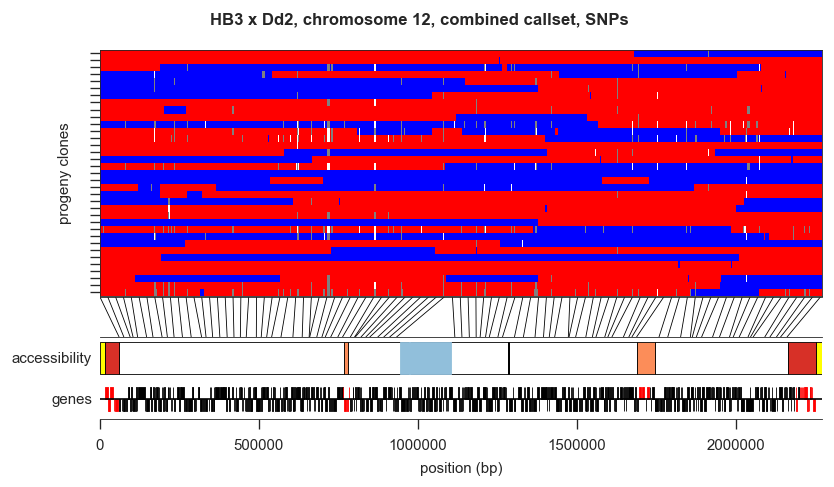

In [28]:
chrom = 'Pf3D7_12_v3'
callsets = combined_snp
cross = 'hb3_dd2'
fig = plt.figure(figsize=(7, 4))
fig.suptitle('%s, chromosome %s, combined callset, SNPs' % (LABELS[cross], int(chrom[6:8])), 
             fontsize=10, fontweight='bold')
fig_inheritance(fig, callsets, cross, chrom, step=10)
fn = '../../artwork/supp/inheritance_combined_snps.{dpi}.{fmt}'
for fmt in 'jpeg', 'png':
    for dpi in 120, 300:
        fig.savefig(fn.format(dpi=dpi, fmt=fmt), dpi=dpi, jpeg_quality=100)


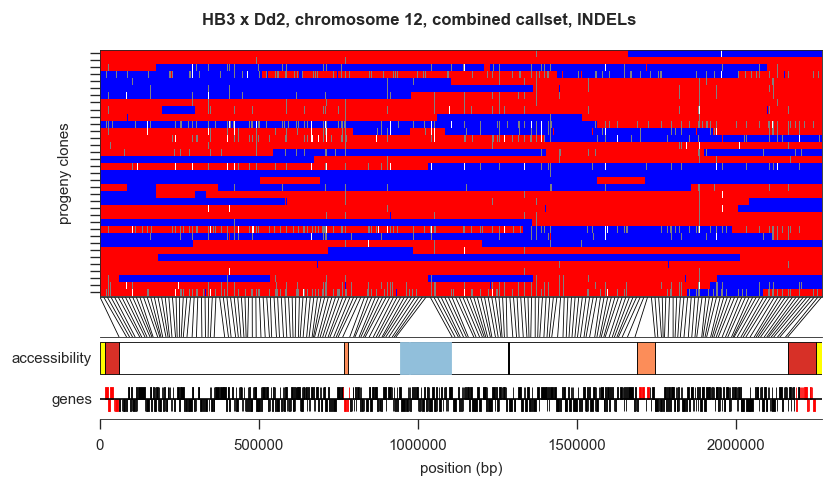

In [29]:
chrom = 'Pf3D7_12_v3'
callsets = combined_indel
cross = 'hb3_dd2'
fig = plt.figure(figsize=(7, 4))
fig.suptitle('%s, chromosome %s, combined callset, INDELs' % (LABELS[cross], int(chrom[6:8])), 
             fontsize=10, fontweight='bold')
fig_inheritance(fig, callsets, cross, chrom, step=10)
fn = '../../artwork/supp/inheritance_combined_indel.{dpi}.{fmt}'
for fmt in 'jpeg', 'png':
    for dpi in 120, 300:
        fig.savefig(fn.format(dpi=dpi, fmt=fmt), dpi=dpi, jpeg_quality=100)
